In [1]:
### import required libraries and pkgs ###
import glob
import os
import librosa
import numpy as np
#from sklearn.model_selection import KFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:

def Myextract_features(filePath, sampleRate=44100):
    factor = 0.4 #alpha
    
    signal,sr = librosa.load(filePath, sampleRate)
    signal = librosa.effects.time_stretch(signal,factor)
    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc,centroid),axis=0)
    #features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [3]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 149, 646)
(9428,)
(1282, 149, 646)
(1282,)
(10710, 149, 646)


In [4]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 149, 646)
(2142, 149, 646)
(1714, 149, 646)
(6854, 149, 646)
(2142, 149, 646)
(1714, 149, 646)


In [5]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 149, 200)     597600      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 149, 200)     387800      ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 149, 200)     0           ['bidirectional[0][0]',          
                                                                  'conv1d[0][0]']             

In [6]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)

Epoch 1/20
54/54 [==============================] - 30s 509ms/step - loss: 228.6824 - accuracy: 0.8912 - mean_squared_error: 0.5000 - val_loss: 27.0919 - val_accuracy: 0.9755 - val_mean_squared_error: 0.5000
Epoch 2/20
54/54 [==============================] - 20s 379ms/step - loss: 30.3910 - accuracy: 0.9608 - mean_squared_error: 0.5000 - val_loss: 12.9208 - val_accuracy: 0.9842 - val_mean_squared_error: 0.5000
Epoch 3/20
54/54 [==============================] - 21s 382ms/step - loss: 16.5733 - accuracy: 0.9743 - mean_squared_error: 0.5000 - val_loss: 7.5532 - val_accuracy: 0.9877 - val_mean_squared_error: 0.5000
Epoch 4/20
54/54 [==============================] - 24s 438ms/step - loss: 13.0069 - accuracy: 0.9764 - mean_squared_error: 0.4999 - val_loss: 6.7603 - val_accuracy: 0.9889 - val_mean_squared_error: 0.5000
Epoch 5/20
54/54 [==============================] - 23s 422ms/step - loss: 8.1074 - accuracy: 0.9856 - mean_squared_error: 0.4999 - val_loss: 5.4824 - val_accuracy: 0.9889 -

In [7]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.980392
Precision: 0.979855
Recall: 0.998421
F1 score: 0.989051
Cohens kappa: 0.895380
ROC AUC: 0.918632
[[ 203   39]
 [   3 1897]]


In [8]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.986577
Precision: 0.985231
Recall: 0.999667
F1 score: 0.992397
Cohens kappa: 0.935209
ROC AUC: 0.946767
[[ 758   90]
 [   2 6004]]


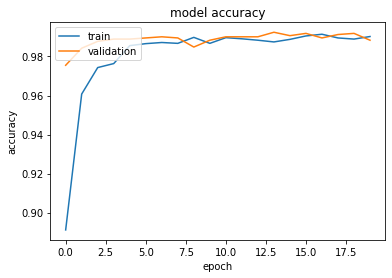

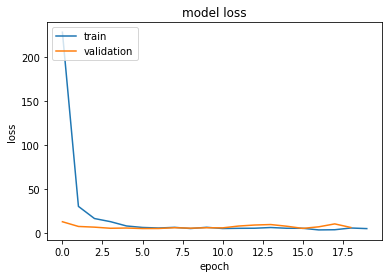

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 149, 200)    597600      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 149, 200)     387800      ['input_2[0][0]']                
                                                                                                  
 add_1 (Add)                    (None, 149, 200)     0           ['bidirectional_1[0][0]',  

In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)

Epoch 1/20
54/54 [==============================] - 27s 443ms/step - loss: 0.3037 - accuracy: 0.9006 - mean_squared_error: 0.3910 - val_loss: 0.2278 - val_accuracy: 0.9726 - val_mean_squared_error: 0.4995
Epoch 2/20
54/54 [==============================] - 23s 425ms/step - loss: 0.0932 - accuracy: 0.9848 - mean_squared_error: 0.4515 - val_loss: 0.0457 - val_accuracy: 0.9889 - val_mean_squared_error: 0.4939
Epoch 3/20
54/54 [==============================] - 23s 432ms/step - loss: 0.0617 - accuracy: 0.9875 - mean_squared_error: 0.4727 - val_loss: 0.0446 - val_accuracy: 0.9854 - val_mean_squared_error: 0.4962
Epoch 4/20
54/54 [==============================] - 23s 424ms/step - loss: 0.0487 - accuracy: 0.9905 - mean_squared_error: 0.4797 - val_loss: 0.0337 - val_accuracy: 0.9895 - val_mean_squared_error: 0.4958
Epoch 5/20
54/54 [==============================] - 22s 411ms/step - loss: 0.0446 - accuracy: 0.9911 - mean_squared_error: 0.4852 - val_loss: 0.1120 - val_accuracy: 0.9942 - val_me

In [12]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.989262
Precision: 0.993169
Recall: 0.994737
F1 score: 0.993952
Cohens kappa: 0.946135
ROC AUC: 0.970509
[[ 229   13]
 [  10 1890]]


In [13]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995623
Precision: 0.998665
Recall: 0.996337
F1 score: 0.997500
Cohens kappa: 0.979956
ROC AUC: 0.993452
[[ 840    8]
 [  22 5984]]


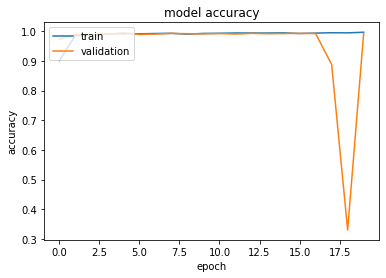

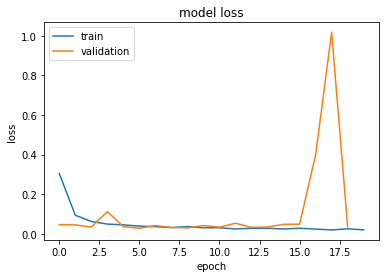

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model2 = Model(inputs, outputs)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 149, 200)    597600      ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 149, 200)     387800      ['input_4[0][0]']                
                                                                                                  
 add_3 (Add)                    (None, 149, 200)     0           ['bidirectional_3[0][0]',  

In [19]:
model2.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model2.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)

Epoch 1/20
54/54 [==============================] - 25s 418ms/step - loss: 0.3053 - accuracy: 0.8990 - mean_squared_error: 0.3912 - val_loss: 0.2829 - val_accuracy: 0.9714 - val_mean_squared_error: 0.4996
Epoch 2/20
54/54 [==============================] - 21s 394ms/step - loss: 0.0902 - accuracy: 0.9834 - mean_squared_error: 0.4555 - val_loss: 0.0706 - val_accuracy: 0.9796 - val_mean_squared_error: 0.4969
Epoch 3/20
54/54 [==============================] - 21s 386ms/step - loss: 0.0614 - accuracy: 0.9888 - mean_squared_error: 0.4738 - val_loss: 0.0557 - val_accuracy: 0.9813 - val_mean_squared_error: 0.4964
Epoch 4/20
54/54 [==============================] - 21s 392ms/step - loss: 0.0447 - accuracy: 0.9910 - mean_squared_error: 0.4808 - val_loss: 0.0417 - val_accuracy: 0.9889 - val_mean_squared_error: 0.4963
Epoch 5/20
54/54 [==============================] - 21s 391ms/step - loss: 0.0381 - accuracy: 0.9911 - mean_squared_error: 0.4862 - val_loss: 0.0316 - val_accuracy: 0.9889 - val_me

In [20]:
#test
pred = model2.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.988329
Precision: 0.990581
Recall: 0.996316
F1 score: 0.993440
Cohens kappa: 0.940590
ROC AUC: 0.960968
[[ 224   18]
 [   7 1893]]


In [21]:
#train
from sklearn.metrics import confusion_matrix

pred = model2.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995039
Precision: 0.995355
Recall: 0.999001
F1 score: 0.997175
Cohens kappa: 0.976865
ROC AUC: 0.982991
[[ 820   28]
 [   6 6000]]


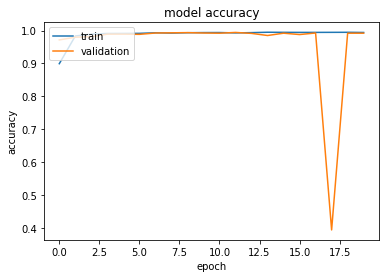

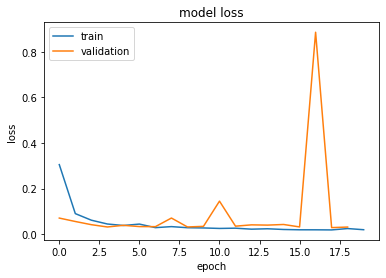

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model4 = Model(inputs, outputs)
model4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 149, 200)    597600      ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 149, 200)     387800      ['input_6[0][0]']                
                                                                                                  
 add_5 (Add)                    (None, 149, 200)     0           ['bidirectional_5[0][0]',  

In [26]:
model4.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model4.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 24s 410ms/step - loss: 0.3554 - accuracy: 0.8783 - mean_squared_error: 0.3880 - val_loss: 0.2392 - val_accuracy: 0.9726 - val_mean_squared_error: 0.4994
Epoch 2/30
54/54 [==============================] - 21s 388ms/step - loss: 0.0988 - accuracy: 0.9825 - mean_squared_error: 0.4514 - val_loss: 0.0802 - val_accuracy: 0.9784 - val_mean_squared_error: 0.4970
Epoch 3/30
54/54 [==============================] - 21s 386ms/step - loss: 0.0635 - accuracy: 0.9882 - mean_squared_error: 0.4702 - val_loss: 0.0471 - val_accuracy: 0.9848 - val_mean_squared_error: 0.4958
Epoch 4/30
54/54 [==============================] - 23s 422ms/step - loss: 0.0554 - accuracy: 0.9891 - mean_squared_error: 0.4784 - val_loss: 0.0431 - val_accuracy: 0.9860 - val_mean_squared_error: 0.4963
Epoch 5/30
54/54 [==============================] - 22s 403ms/step - loss: 0.0431 - accuracy: 0.9905 - mean_squared_error: 0.4835 - val_loss: 0.0383 - val_accuracy: 0.9918 - val_me

In [27]:
#train
from sklearn.metrics import confusion_matrix

pred = model2.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995039
Precision: 0.995355
Recall: 0.999001
F1 score: 0.997175
Cohens kappa: 0.976865
ROC AUC: 0.982991
[[ 820   28]
 [   6 6000]]


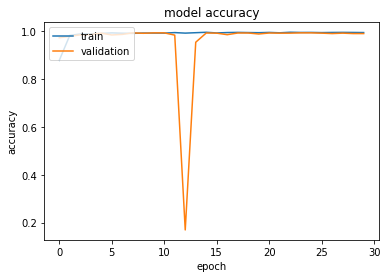

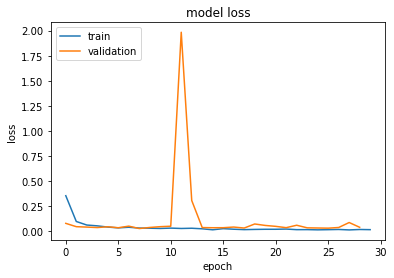

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
#test
pred = model2.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.988329
Precision: 0.990581
Recall: 0.996316
F1 score: 0.993440
Cohens kappa: 0.940590
ROC AUC: 0.960968
[[ 224   18]
 [   7 1893]]


In [30]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model5 = Model(inputs, outputs)
model5.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 149, 200)    597600      ['input_7[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 149, 200)     387800      ['input_7[0][0]']                
                                                                                                  
 add_6 (Add)                    (None, 149, 200)     0           ['bidirectional_6[0][0]',  

In [31]:
model5.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model5.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 25s 420ms/step - loss: 96.7507 - accuracy: 0.9200 - mean_squared_error: 0.4999 - val_loss: 20.6073 - val_accuracy: 0.9761 - val_mean_squared_error: 0.5000
Epoch 2/30
54/54 [==============================] - 22s 388ms/step - loss: 25.1690 - accuracy: 0.9628 - mean_squared_error: 0.4999 - val_loss: 13.9624 - val_accuracy: 0.9796 - val_mean_squared_error: 0.5000
Epoch 3/30
54/54 [==============================] - 21s 385ms/step - loss: 15.0418 - accuracy: 0.9771 - mean_squared_error: 0.4999 - val_loss: 9.7846 - val_accuracy: 0.9907 - val_mean_squared_error: 0.5000
Epoch 4/30
54/54 [==============================] - 20s 380ms/step - loss: 10.0534 - accuracy: 0.9831 - mean_squared_error: 0.4999 - val_loss: 8.8296 - val_accuracy: 0.9872 - val_mean_squared_error: 0.5000
Epoch 5/30
54/54 [==============================] - 21s 380ms/step - loss: 7.6334 - accuracy: 0.9854 - mean_squared_error: 0.4999 - val_loss: 6.6961 - val_accuracy: 0.9889 - 

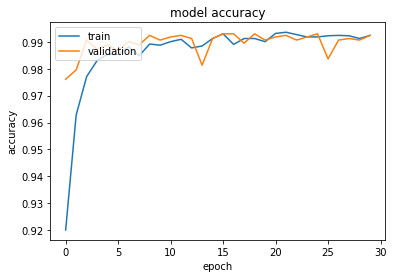

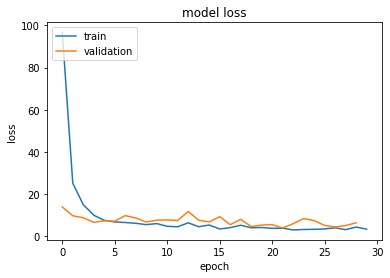

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model9 = Model(inputs, outputs)
model9.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 149, 200)    597600      ['input_8[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_14 (Conv1D)             (None, 149, 200)     387800      ['input_8[0][0]']                
                                                                                                  
 add_7 (Add)                    (None, 149, 200)     0           ['bidirectional_7[0][0]',  

In [34]:
model9.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model9.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 32s 519ms/step - loss: 104.8376 - accuracy: 0.9126 - mean_squared_error: 0.4999 - val_loss: 27.0548 - val_accuracy: 0.9737 - val_mean_squared_error: 0.5000
Epoch 2/30
54/54 [==============================] - 21s 391ms/step - loss: 24.0413 - accuracy: 0.9609 - mean_squared_error: 0.4999 - val_loss: 12.3117 - val_accuracy: 0.9860 - val_mean_squared_error: 0.5000
Epoch 3/30
54/54 [==============================] - 24s 445ms/step - loss: 13.2905 - accuracy: 0.9788 - mean_squared_error: 0.5000 - val_loss: 8.8063 - val_accuracy: 0.9877 - val_mean_squared_error: 0.5000
Epoch 4/30
54/54 [==============================] - 23s 424ms/step - loss: 11.2286 - accuracy: 0.9781 - mean_squared_error: 0.5000 - val_loss: 11.8542 - val_accuracy: 0.9872 - val_mean_squared_error: 0.5000
Epoch 5/30
54/54 [==============================] - 23s 428ms/step - loss: 8.0726 - accuracy: 0.9851 - mean_squared_error: 0.5000 - val_loss: 7.2926 - val_accuracy: 0.9872 

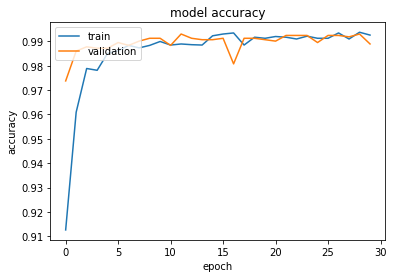

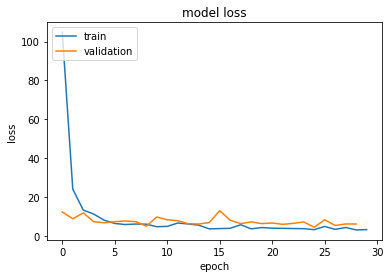

In [35]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model1 = Model(inputs, outputs)
model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 149, 200)    597600      ['input_9[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 149, 200)     387800      ['input_9[0][0]']                
                                                                                                  
 add_8 (Add)                    (None, 149, 200)     0           ['bidirectional_8[0][0]',  

In [37]:
model1.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model1.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 27s 409ms/step - loss: 0.3245 - accuracy: 0.8865 - mean_squared_error: 0.3929 - val_loss: 0.2745 - val_accuracy: 0.9726 - val_mean_squared_error: 0.4996
Epoch 2/30
54/54 [==============================] - 26s 486ms/step - loss: 0.0983 - accuracy: 0.9821 - mean_squared_error: 0.4534 - val_loss: 0.0606 - val_accuracy: 0.9825 - val_mean_squared_error: 0.4966
Epoch 3/30
54/54 [==============================] - 31s 569ms/step - loss: 0.0586 - accuracy: 0.9901 - mean_squared_error: 0.4711 - val_loss: 0.0570 - val_accuracy: 0.9819 - val_mean_squared_error: 0.4968
Epoch 4/30
54/54 [==============================] - 31s 583ms/step - loss: 0.0487 - accuracy: 0.9907 - mean_squared_error: 0.4807 - val_loss: 0.0314 - val_accuracy: 0.9924 - val_mean_squared_error: 0.4943
Epoch 5/30
54/54 [==============================] - 31s 575ms/step - loss: 0.0483 - accuracy: 0.9910 - mean_squared_error: 0.4815 - val_loss: 0.0498 - val_accuracy: 0.9924 - val_me

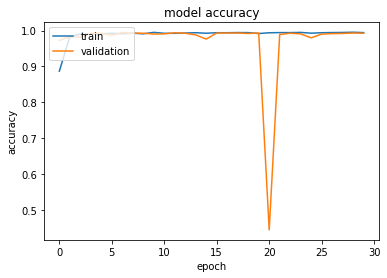

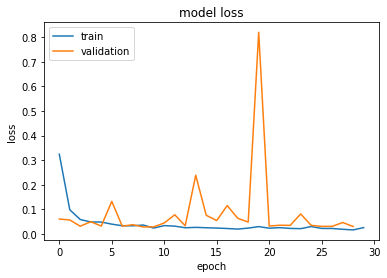

In [38]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model10 = Model(inputs, outputs)
model10.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 149, 200)    597600      ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 149, 200)     387800      ['input_10[0][0]']               
                                                                                                  
 add_9 (Add)                    (None, 149, 200)     0           ['bidirectional_9[0][0]',  

In [40]:
model10.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model10.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 26s 421ms/step - loss: 117.4182 - accuracy: 0.9171 - mean_squared_error: 0.5000 - val_loss: 22.8212 - val_accuracy: 0.9796 - val_mean_squared_error: 0.5000
Epoch 2/30
54/54 [==============================] - 20s 379ms/step - loss: 24.6528 - accuracy: 0.9618 - mean_squared_error: 0.4999 - val_loss: 13.3605 - val_accuracy: 0.9825 - val_mean_squared_error: 0.5000
Epoch 3/30
54/54 [==============================] - 23s 430ms/step - loss: 13.5799 - accuracy: 0.9742 - mean_squared_error: 0.5000 - val_loss: 10.7921 - val_accuracy: 0.9842 - val_mean_squared_error: 0.5000
Epoch 4/30
54/54 [==============================] - 25s 458ms/step - loss: 10.3115 - accuracy: 0.9802 - mean_squared_error: 0.4999 - val_loss: 10.1139 - val_accuracy: 0.9877 - val_mean_squared_error: 0.5000
Epoch 5/30
54/54 [==============================] - 25s 470ms/step - loss: 8.1398 - accuracy: 0.9875 - mean_squared_error: 0.5000 - val_loss: 10.1741 - val_accuracy: 0.984

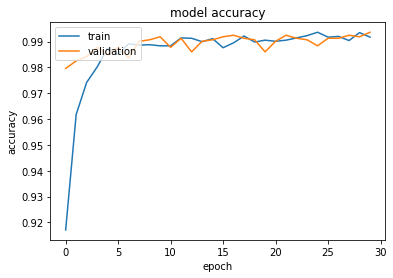

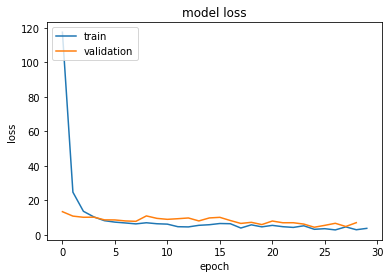

In [41]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model12 = Model(inputs, outputs)
model12.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 149, 200)    597600      ['input_11[0][0]']               
 l)                                                                                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 149, 200)     387800      ['input_11[0][0]']               
                                                                                                  
 add_10 (Add)                   (None, 149, 200)     0           ['bidirectional_10[0][0]',

In [43]:
model12.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model12.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 33s 548ms/step - loss: 161.3573 - accuracy: 0.9071 - mean_squared_error: 0.4999 - val_loss: 38.2433 - val_accuracy: 0.9737 - val_mean_squared_error: 0.5000
Epoch 2/30
54/54 [==============================] - 20s 379ms/step - loss: 33.3298 - accuracy: 0.9615 - mean_squared_error: 0.5000 - val_loss: 17.8979 - val_accuracy: 0.9807 - val_mean_squared_error: 0.5000
Epoch 3/30
54/54 [==============================] - 20s 377ms/step - loss: 19.4034 - accuracy: 0.9714 - mean_squared_error: 0.4999 - val_loss: 12.5222 - val_accuracy: 0.9848 - val_mean_squared_error: 0.5000
Epoch 4/30
54/54 [==============================] - 21s 383ms/step - loss: 11.2317 - accuracy: 0.9821 - mean_squared_error: 0.5000 - val_loss: 8.4514 - val_accuracy: 0.9895 - val_mean_squared_error: 0.5000
Epoch 5/30
54/54 [==============================] - 22s 416ms/step - loss: 14.6368 - accuracy: 0.9788 - mean_squared_error: 0.5000 - val_loss: 8.4489 - val_accuracy: 0.9889

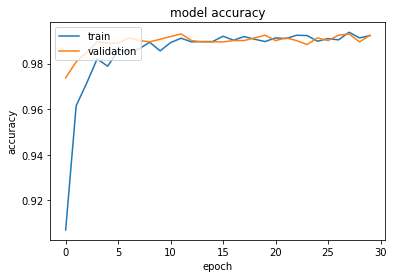

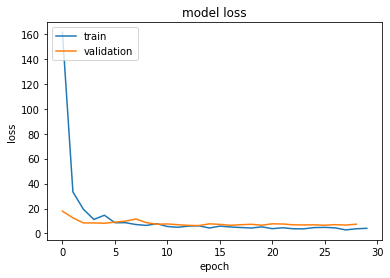

In [44]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
#test
pred = model5.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.989262
Precision: 0.992651
Recall: 0.995263
F1 score: 0.993955
Cohens kappa: 0.945939
ROC AUC: 0.968706
[[ 228   14]
 [   9 1891]]


In [51]:
#train
from sklearn.metrics import confusion_matrix

pred = model5.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995769
Precision: 0.998166
Recall: 0.997003
F1 score: 0.997584
Cohens kappa: 0.980556
ROC AUC: 0.992016
[[ 837   11]
 [  18 5988]]


In [52]:
#train
from sklearn.metrics import confusion_matrix

pred = model1.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.994748
Precision: 0.996838
Recall: 0.997169
F1 score: 0.997003
Cohens kappa: 0.975752
ROC AUC: 0.987382
[[ 829   19]
 [  17 5989]]


In [62]:
#test
pred = model1.predict(X_test)
y_pred = [0 if y[0]>.90 else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.989262
Precision: 0.990591
Recall: 0.997368
F1 score: 0.993968
Cohens kappa: 0.945141
ROC AUC: 0.961494
[[ 224   18]
 [   5 1895]]
